In [1]:
import copy
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import scipy
import time
import glob
import xarray as xr
import cartopy.crs as ccrs

from pandas import DataFrame
from properscoring import crps_ensemble
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
from ensemble_evaluation_functions import *

In [3]:
def plot_metric(metric,lat,lon,name_metric,ideal_val,cmap='viridis',
                vmin=None,vmax=None,units=None,cbar_label=None,path_save=None):
    # Set up the projection and plot the data
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    p = ax.pcolormesh(lon, lat, metric, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)

    # Set up the colorbar
    if cbar_label is not None:
        cbar_label = f"({var.units})"
    cbar = plt.colorbar(p, ax=ax, orientation='horizontal', shrink=0.5, pad=0.1)
    cbar.ax.set_xlabel(cbar_label)

    # Add coastlines and gridlines
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    # Set the title
    ax.set_title(f'{name_metric}\nAverage: {str(np.round(np.mean(metric),2))}\n(Ideal value: {ideal_val})', fontsize=14)
    if path_save == None:
        plt.show()
    else:
        plt.savefig(path_save,bbox_inches='tight')
    # return fig
    

In [4]:
path_base = '/glade/derecho/scratch/molina/'

3
4


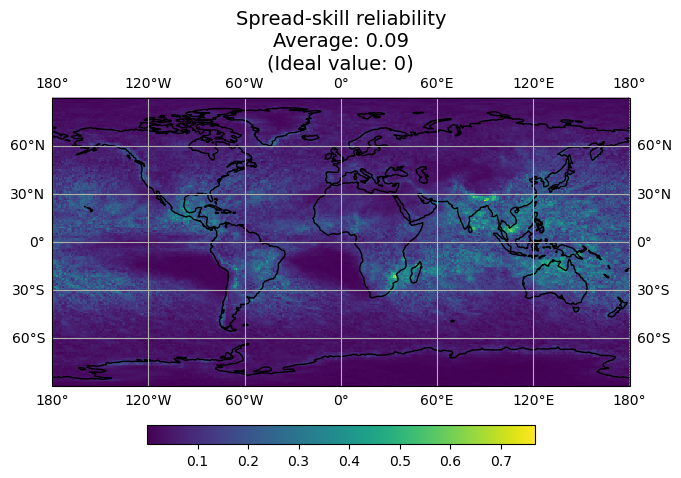

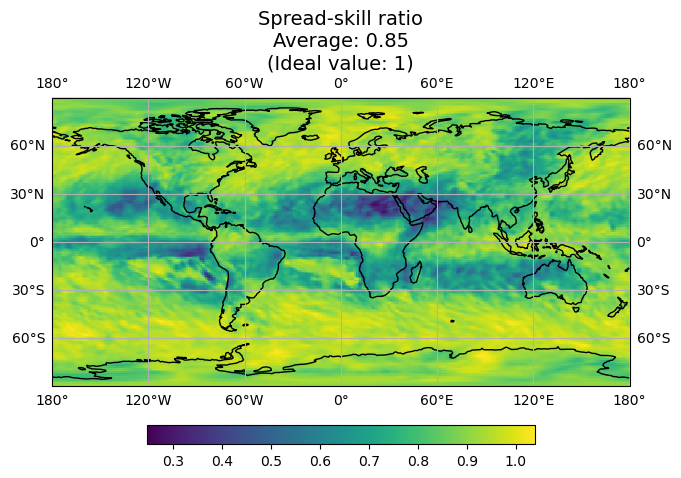

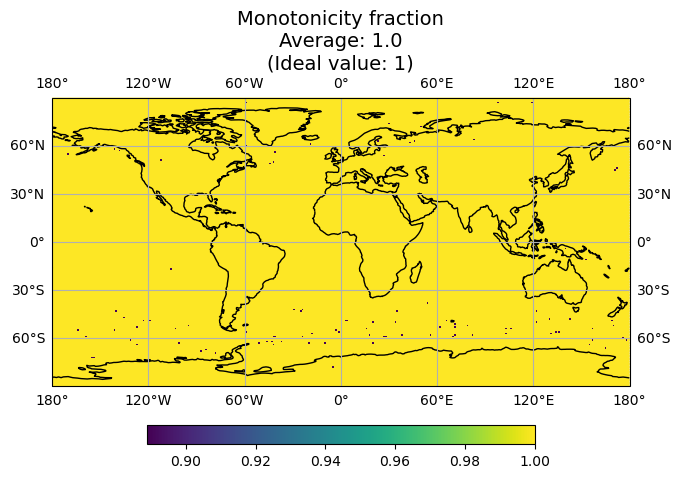

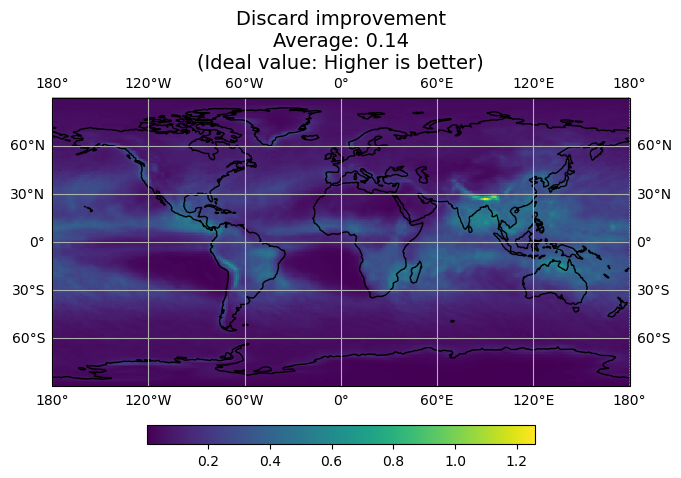

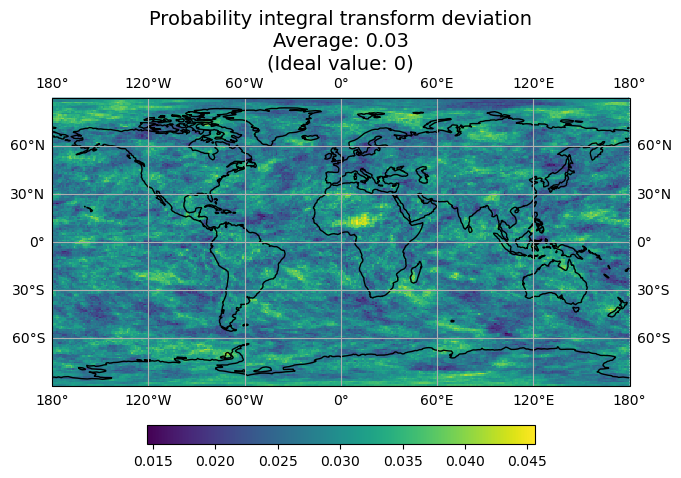

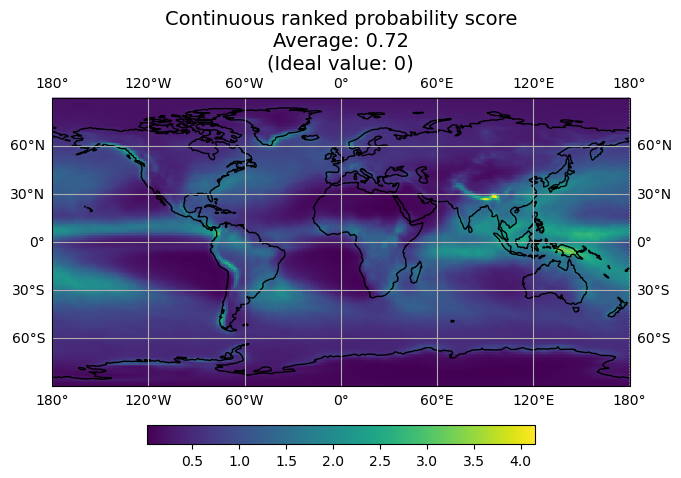

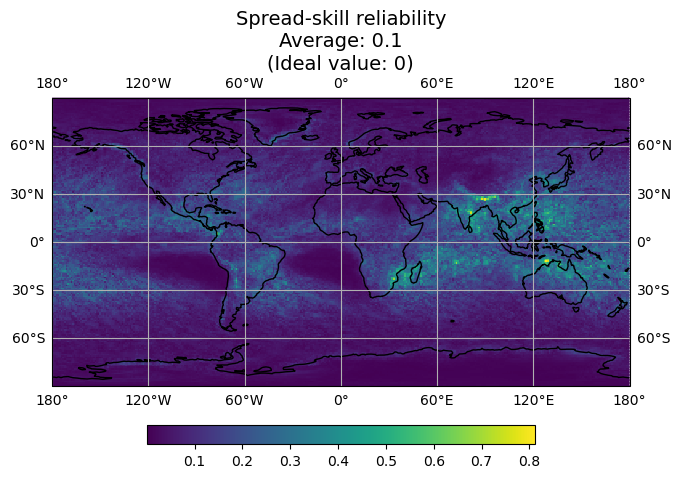

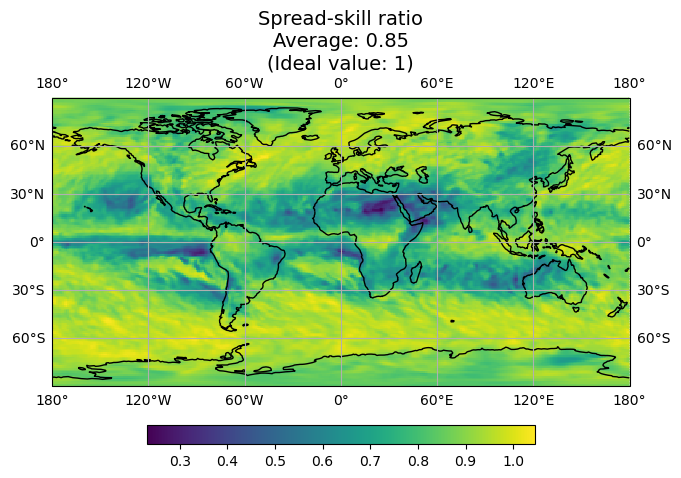

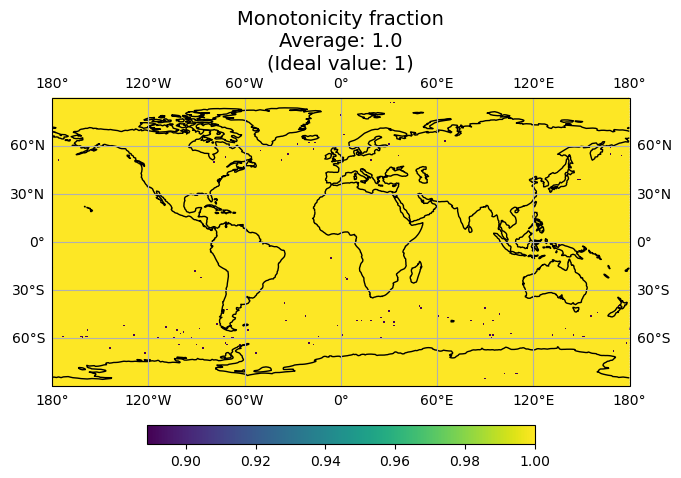

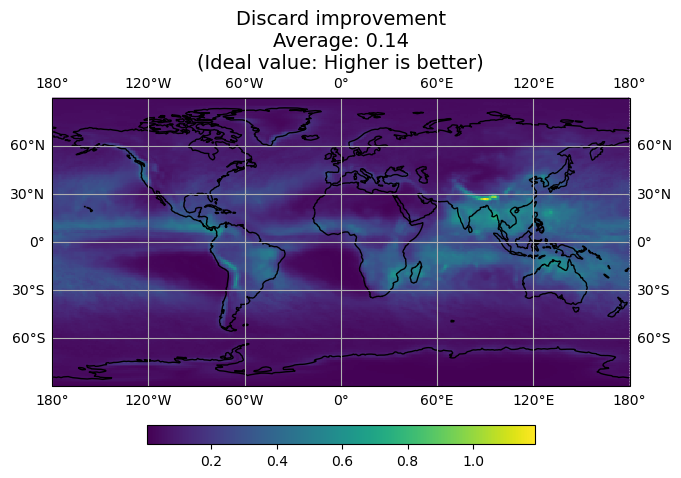

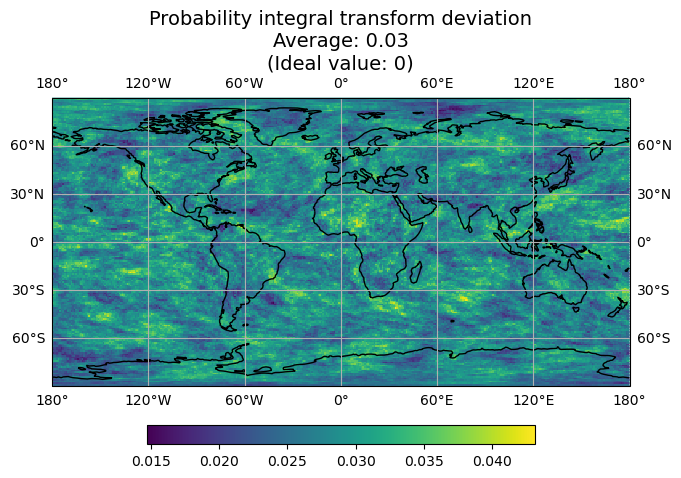

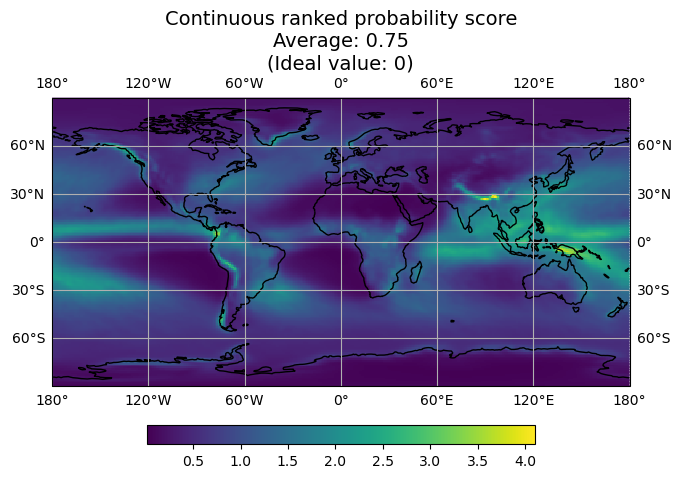

In [5]:
for week in [3,4]:
    print(week)
    folders_ensembles = np.sort(glob.glob(f'{path_base}cesm_prsfc_week{week}_m*/'))
    list_arrays = []
    for folder in folders_ensembles:
        # print(folder)
        list_files = np.sort(glob.glob(f'{folder}*.nc'))
        dataset_member = xr.open_mfdataset(list_files,combine='nested',concat_dim="time")
        dataarray_member = dataset_member.pr_sfc[:,0,0,:,:].drop_vars(['sample','ens'])
        list_arrays.append(dataarray_member)
        
    ensemble = xr.concat(list_arrays,dim='member').transpose('time','lat','lon','member')
    ensemble = ensemble.load()

    files_era = np.sort(glob.glob(f'{path_base}era5_prsfc_week{week}/*.nc'))
    dataset_era = xr.open_mfdataset(list_files,combine='nested',concat_dim="time")
    dataarray_era = dataset_member.pr_sfc[:,0,0,:,:].drop_vars(['sample','ens'])
    dataarray_era = dataarray_era.load()
    
    ### Compute metrics
    
    ssrel,ssrat = get_spread_skill_2d(dataarray_era.values,ensemble.values)
    mf,di = get_discard_skill_2d(dataarray_era.values,ensemble.values)
    pitd = get_pitd_2d(dataarray_era.values,ensemble.values)
    crps = get_crps_2d(dataarray_era.values,ensemble.values)
    # ign = get_ign_2d(dataarray_era.values,ensemble.values)
    
    metrics = [ssrel, ssrat, mf, di, pitd, crps]
    names_metrics = ['Spread-skill reliability',
             'Spread-skill ratio',
             'Monotonicity fraction',
             'Discard improvement',
             'Probability integral transform deviation',
             'Continuous ranked probability score'
                    ]
    short_names_metrics = ['ssrel', 'ssrat', 'mf', 'di', 'pitd', 'crps']
    ideal_val_metric = ['0', '1', '1', 'Higher is better', '0', '0']
    
    lat = dataset_era.lat
    lon = dataset_era.lon
    
    for i in range(len(metrics)):
        data_array = xr.DataArray(metrics[i], dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
        data_array.to_netcdf(f'OutputEvaluation/eval_cesm_prsfc_week{week}_{short_names_metrics[i]}.nc')
        plot_metric(metrics[i],lat,lon,names_metrics[i],ideal_val_metric[i],
                    path_save = f'Figures/eval_cesm_prsfc_week{week}_{short_names_metrics[i]}.png')